# Fast Hough Transform

## Решение

Решение было основано на [статье](http://www.jip.ru/2017/294-308-2017.pdf).
Алгоритм FHT реализован для преимущественно-горизонтальных прямых с наклоном вниз (t < 0).

Для поиска прямых другого типа и применения найденного угла наклона строк предлагается повернуть или отобразить изображение таким образом, чтобы задача состояла в поиске ПГП с наклоном вверх:

```
- ПГП + t > 0: rotate(angle)
- ПГП + t < 0: img[::-1, :]; get angle; img[::-1, :]; rotate(angle)
- ПВП + t < 0: rotate(90); get angle; rotate(-90); rotate(angle)
- ПВП + t > 0: rotate(90); img[::-1, :]; get angle; rotate(90); img[::-1, :]; rotate(angle)
```

<img src="./cases.png " alt="Drawing" style="width: 500px;"/>

In [1]:
%matplotlib inline

import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.setrecursionlimit(2000)

DATA_PATH = './data/'

In [2]:
def merge_parts(p0, p1):
    h = p0.shape[0]
    w = p0.shape[1] * 2
    A = np.zeros((h, w))
    
    for strip in range(w):
        strip_ = int(strip / 2)
        shift = strip - strip_
        A[:, strip] = p0[:, strip_] + np.concatenate([p1[shift:, strip_], p1[:shift, strip_]], axis = 0)
    return A

    
def fht(img):
    h, w = img.shape
    if w < 2:
        return img[:, 0].reshape((h, 1))
    else:
        mid = w // 2
        return merge_parts(fht(img[:, :mid]), fht(img[:, mid:]))
    
    
def rotate(img, angle):
    h, w = img.shape
    center = (h / 2, w / 2)
    rot = cv2.getRotationMatrix2D(center, angle, 1.0) 
    img = cv2.warpAffine(img, rot, (w, h), flags=cv2.INTER_NEAREST)
    return img
    
    
def get_angle(a, ext=False):
    h, w = a.shape
    max_idx = np.argmax(np.var(a, axis=0))
#     max_value = max(a[max_idx, :])
    max_var = np.var(a, axis=0)[max_idx]
    angle = np.rad2deg(np.arctan(max_idx / w))
    
    if ext:
        return (a, max_idx), (max_var, angle)
    return angle

    
def get_fht_angle(img, visualize=True):
    h, w = np.array(img).shape
    rotated = np.rot90(img, 1)
    h_r, w_r = rotated.shape
    
    if w & (w - 1) != 0:
        w_pow = 128
        scale = w_pow / w
        img = cv2.resize(img, (int(w_pow), int(scale * h)), cv2.INTER_CUBIC)
        
    if w_r & (w_r - 1) != 0:
        w_pow = 128
        scale_r = w_pow / w_r
        rotated = cv2.resize(rotated, (int(w_pow), int(scale_r * h_r)), cv2.INTER_CUBIC)
    
    cases = ['identical', 'rotated', 'mirror', 'rotated & mirror']
    i_vis, i_val = get_angle(fht(img), True)
    r_vis, r_val = get_angle(fht(rotated), True)
    m_vis, m_val = get_angle(fht(img[::-1, :]), True)
    mr_vis, mr_val = get_angle(fht(rotated[::-1, :]), True)
    vals = np.array([i_val, r_val, m_val, mr_val])
    
    if visualize:
        f, ax = plt.subplots(2, 2, figsize = (10, 10))
        f.suptitle('FHT for all possible cases')
        ax[0, 0].imshow(i_vis[0], cmap='gray')
        ax[0, 0].plot([i_vis[1]] * int(scale * h), np.arange(int(scale * h)), 'r')
        ax[0, 0].set_title(cases[0])
        ax[0, 1].imshow(r_vis[0], cmap='gray')
        ax[0, 1].plot([r_vis[1]] * int(scale_r * h_r), np.arange(int(scale_r * h_r)), 'r')
        ax[0, 1].set_title(cases[1])
        ax[1, 0].imshow(m_vis[0], cmap='gray')
        ax[1, 0].plot([m_vis[1]] * int(scale * h), np.arange(int(scale * h)), 'r')
        ax[1, 0].set_title(cases[2])
        ax[1, 1].imshow(mr_vis[0], cmap='gray')
        ax[1, 1].plot([mr_vis[1]] * int(scale_r * h_r), np.arange(int(scale_r * h_r)), 'r')
        ax[1, 1].set_title(cases[3])
        plt.show()
    
    max_var = np.argmax(vals[:, 0])
    
    return list(zip(cases, vals[:, 1]))[max_var]

### Пример работы алгоритма на простом изображении

Алгоритм реализован для ПГП с наклоном вниз, поэтому нам нужно отразить изображение, чтобы можно было применить алгоритм.

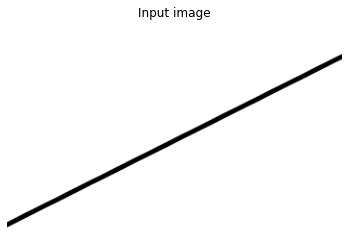

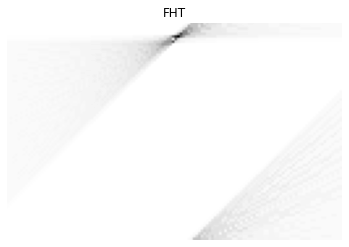

Tilt angle:  26.92202960781027


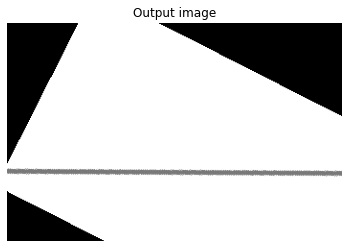

In [3]:
img = cv2.imread(DATA_PATH + '1.png', cv2.IMREAD_GRAYSCALE)
h, w = img.shape

plt.figure(figsize=(6, 6))
plt.title('Input image')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

img_m = img[::-1, :]
img_m = cv2.resize(img_m, (int(128), int(128 / w * h)), cv2.INTER_CUBIC)

fht_res = fht(img_m)
plt.title('FHT')
plt.imshow(fht_res, cmap='gray')
plt.axis('off')
plt.show()

angle = get_angle(fht_res)
print('Tilt angle: ', angle)
img = rotate(img, -angle) 

plt.figure(figsize=(6, 6))
plt.title('Output image')
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

### Описание решения

Для получения решения алгоритм запускается для обнаружения всех возможных видов прямых, \
то есть применяется 4 вида преобразований и для каждого находится угол наклона строк. \
Для получения угла мы находим столбец с максимальной дисперсией, дальше считаем его отношение к ширине, вычисляем arctan и тд. \
Теперь, чтобы определить, какое преобразование лучше всего нашло ПГП с наклоном вниз, а, соответственно, и угол, \
возьмем максимум по всем максимальным дисперсиям преобразований и вернем соответствующий угол.

Image #1


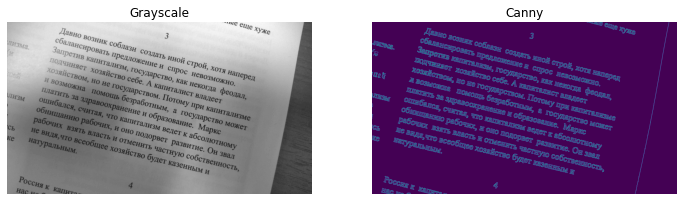

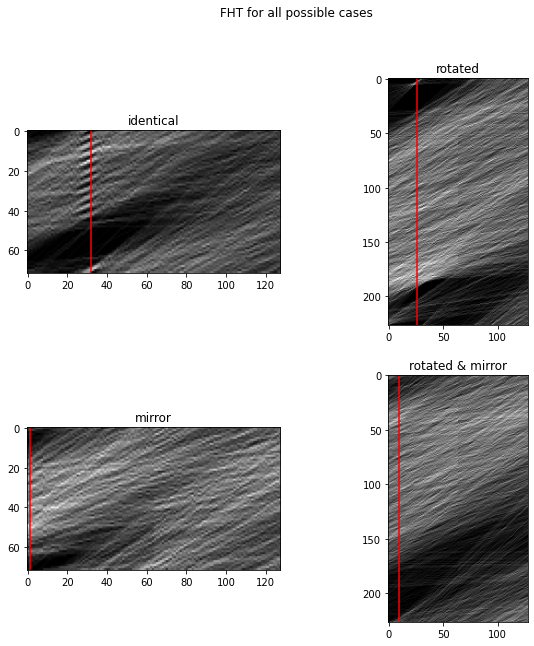

Case: identical
Tilt angle: 14.036243467926479


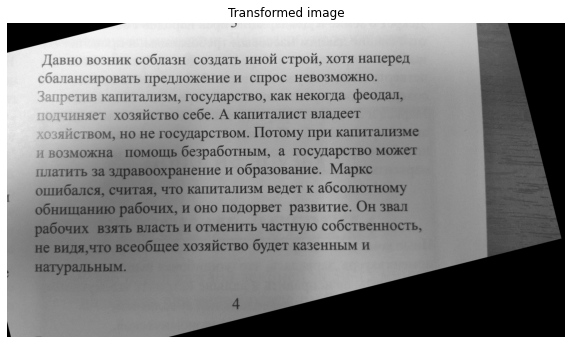

------------------------------------------------------------------------------------------

Image #2


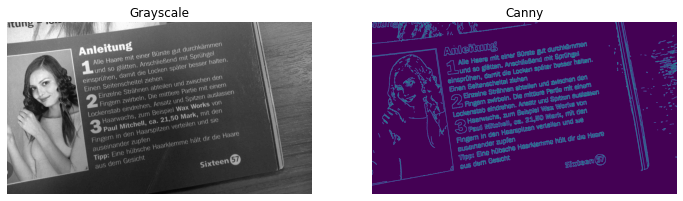

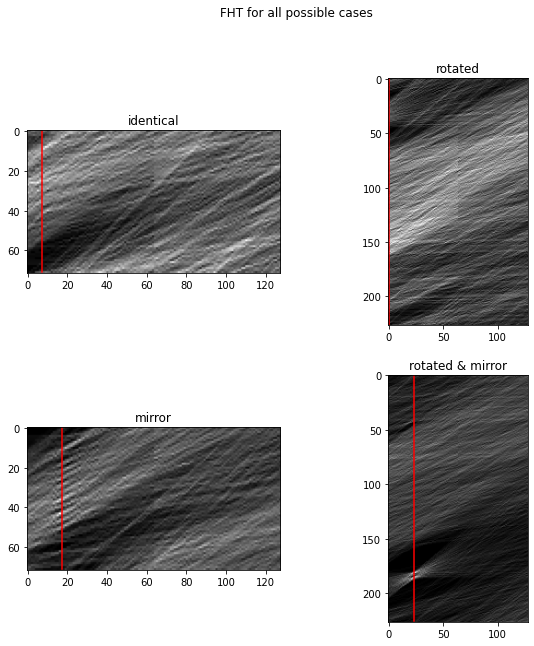

Case: rotated & mirror
Tilt angle: 10.186629759944784


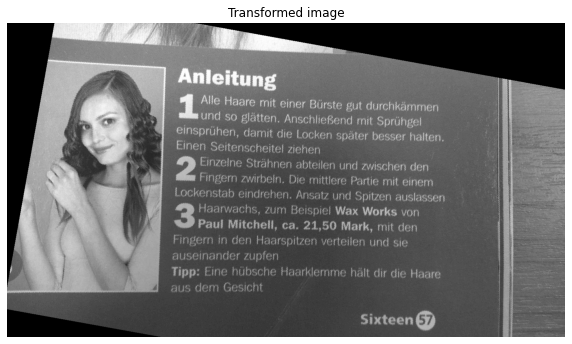

------------------------------------------------------------------------------------------

Image #3


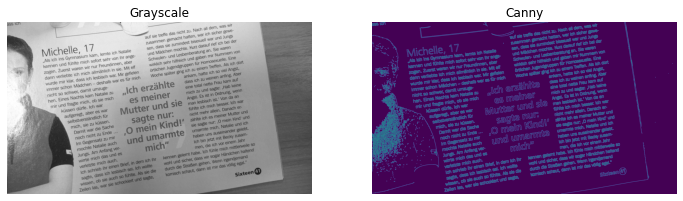

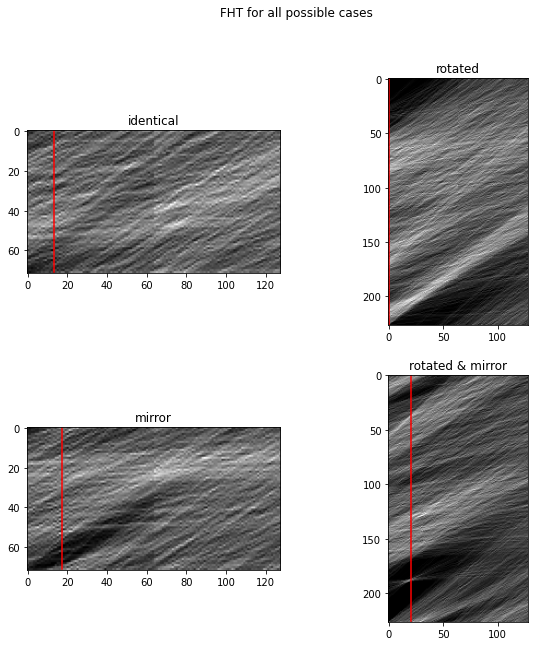

Case: rotated & mirror
Tilt angle: 8.880659150520245


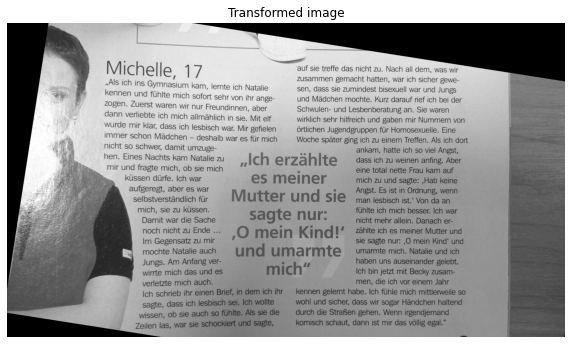

------------------------------------------------------------------------------------------



In [4]:
for i in range(1, 4):
    print('Image #%d' % i)
    img = cv2.imread(DATA_PATH + '%d.jpg' % i, cv2.IMREAD_GRAYSCALE)
    img_canny = cv2.Canny(img, 100, 200, 3)

    f, ax = plt.subplots(1, 2, figsize=(12, 12))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Grayscale')
    ax[0].axis('off')
    ax[1].imshow(img_canny)
    ax[1].set_title('Canny')
    ax[1].axis('off')
    plt.show()

    case, angle = get_fht_angle(img_canny)
    print('Case:', case)
    print('Tilt angle:', angle)

    img = rotate(img, -angle) if case != 'identical' else rotate(img, angle)
    plt.figure(figsize=(10, 10))
    plt.title('Transformed image')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    print('-' * 90)
    print()

## Выводы

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.32it/s]


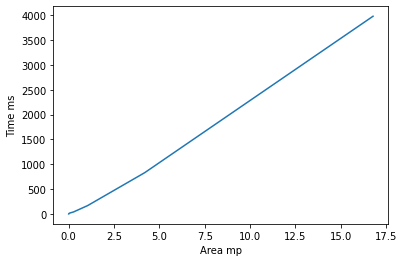

In [5]:
sizes = [(8, 8), (64, 64), (256, 256), (512, 512), (1024, 1024), (2048, 2048), (4096, 4096)]
area_by_time = []

for size in tqdm(sizes):
    img = np.random.uniform(low=0, high=255, size=size)
    start_time = time.time()
    a = fht(img)
    end_time = time.time()
    area_by_time.append((size[0] * size[1] * 1e-6 , (end_time - start_time) * 1e3))
    
area_by_time = np.array(area_by_time)

plt.plot(area_by_time[:, 0], area_by_time[:, 1])
plt.xlabel('Area mp')
plt.ylabel('Time ms')
plt.show()

- суммарная сложность ```O(4*N**2log(N)) -> O(N**2log(N))```
- в качестве оптимизации я бы попровала избавиться от рекурсии, изначально бы посчитала интервалы, а потом их переиспользовала в цикле
- resize к меньшему размеру